## Instructions

See README in [tpc-field-maps](https://gitlab.com/luxzeplin/users/emiz/tpc-field-maps).

In [1]:
import dolfin.common.plotting as dp
import lzef
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import pandas as pd
import ufl.operators as uop
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [33]:
def KM(pitch, radius, b1, b2, V0, V1, V2):
    eps = 1.85
    b = b1 + b2
    K = (pitch * b / (2 * np.pi * b1 * b2)) * np.log((pitch / 2) / (2 * np.pi * radius))
    E = (V0 - V1) / (8 + 5 / eps)
    V11 = V0 - (E * b1)
    dE = b2 / b * ((V0 - V2) / b2 - (V11 - V0) / b1) * (K / (1 + K))
    return -dE * b1

In [3]:
# if this is not found, run gmsh on LZ_realgrids.geo and write to gmsh format 4.
# Or copy it from /global/cfs/cdirs/lz/users/emiz/LZFields/LZElectricField/fem/geometry/LZ_realgrids.msh
filename = "../LZElectricField/fem/geometry/LZ_realgrids.msh"

# [0,2] is because I made it in the X,Z and not the X,Y plane.
problem = lzef.LZProblem(filename, [0, 2])
problem.useDefaultLZ()

# 430 is the Kirk-McDonald Correction
problem.set_dirichlet_lg(cathode=-32e3, bottom=-1275, anode=4e3 - 430, gate=-4e3)

u, E, V = problem.solve_field(axisymmetric=True, verbose=False)

norm_E = uop.sqrt(uop.dot(E, E)) * 10


epsilon PTFE= 2.1
epsilon LXe= 1.874
epsilon PEEK= 3.2
epsilon GXe= 1
Solving linear variational problem.


## Field Magnitude and Equipotentials - Full TPC

Object cannot be plotted directly, projecting to piecewise linears.


(0.0, 737.0)

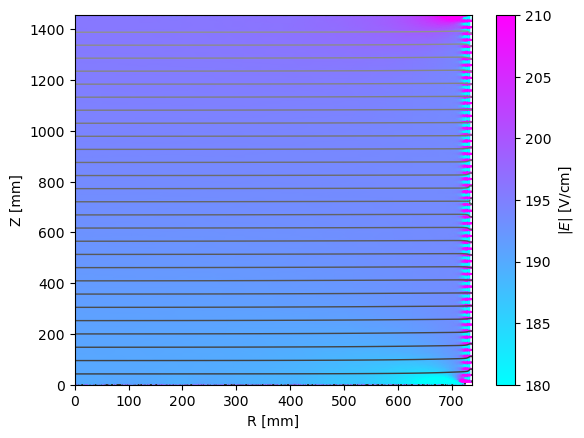

In [4]:
fig, ax = plt.subplots()

triang = tri.Triangulation(
    *problem.mesh.coordinates().T, triangles=problem.mesh.cells()
)
Z = u.compute_vertex_values(V.mesh())

# Special mesh plotting function from dolfin
im = dp.plot(
    norm_E,
    vmin=195 - 15,
    vmax=195 + 15,
    mode="color",
    cmap="cool",
)
plt.tricontour(
    triang,
    Z,
    levels=np.r_[-50000:-4000:1000],
    linewidths=1,
    cmap="gist_gray",
    vmax=30000,
)
plt.gca().set_aspect("auto")
plt.xlabel("R [mm]")
plt.ylabel("Z [mm]")
cbar = plt.colorbar(im)
cbar.set_label(r"$|E|$ [V/cm]")
plt.ylim(0, 1456)
plt.xlim(0, 737)

In [7]:
fig, ax = plt.subplots(dpi=300)

# Eli's style file
plt.style.use(
    "/global/homes/e/emiz/AlpacaAnalysis/modules/sv_SEDecayTime/python/etrain/assets/SetLZStyle.mplstyle"
)

im = dp.plot(norm_E * 1e-3, vmin=0, vmax=10, mode="color", cmap="viridis")
cbar = plt.colorbar(im)
cbar.set_label("Electric Field [kV/cm]")

ax.set(xlim=(0, 50), ylim=(1453, 1471), aspect="auto", xlabel="R [mm]", ylabel="Z [mm]")

ax.text(20, 1454.5, "Drift Liquid", color="white", fontsize=14)
ax.text(3, 1457, "Gate", color="white", fontsize=14)
ax.text(20, 1458.5, "Extraction Liquid", color="white", fontsize=14)
ax.text(3, 1461.5, "Liquid Surface", fontsize=14)
ax.text(3, 1469, "Anode", color="white", fontsize=14)


# Abuse an inset to add a drift time axis
axins = inset_axes(
    ax,
    width="100%",
    height="100%",
    bbox_to_anchor=(-0.25, 0, 0, 0.45),
    bbox_transform=ax.transAxes,
    borderpad=0,
)

# 0 and 5us drift time extrapolated from drift map
axins.set(yticks=[0, 1, 2, 3, 4, 5])
axins.set_ylabel(ylabel="Drift Time [$\mu$s]", labelpad=10)
axins.invert_yaxis()

# Put this behind main figure
axins.set_zorder(-1)

# Disable right tick since stylefile enables them
axins.yaxis.tick_right()

# Make other stuff invisible
axins.xaxis.set_visible(False)
axins.spines["top"].set_visible(False)
axins.spines["bottom"].set_visible(False)
axins.spines["right"].set_visible(False)

# Hide figure output since we can't suppress text for Quarto...
plt.close("all")

Object cannot be plotted directly, projecting to piecewise linears.


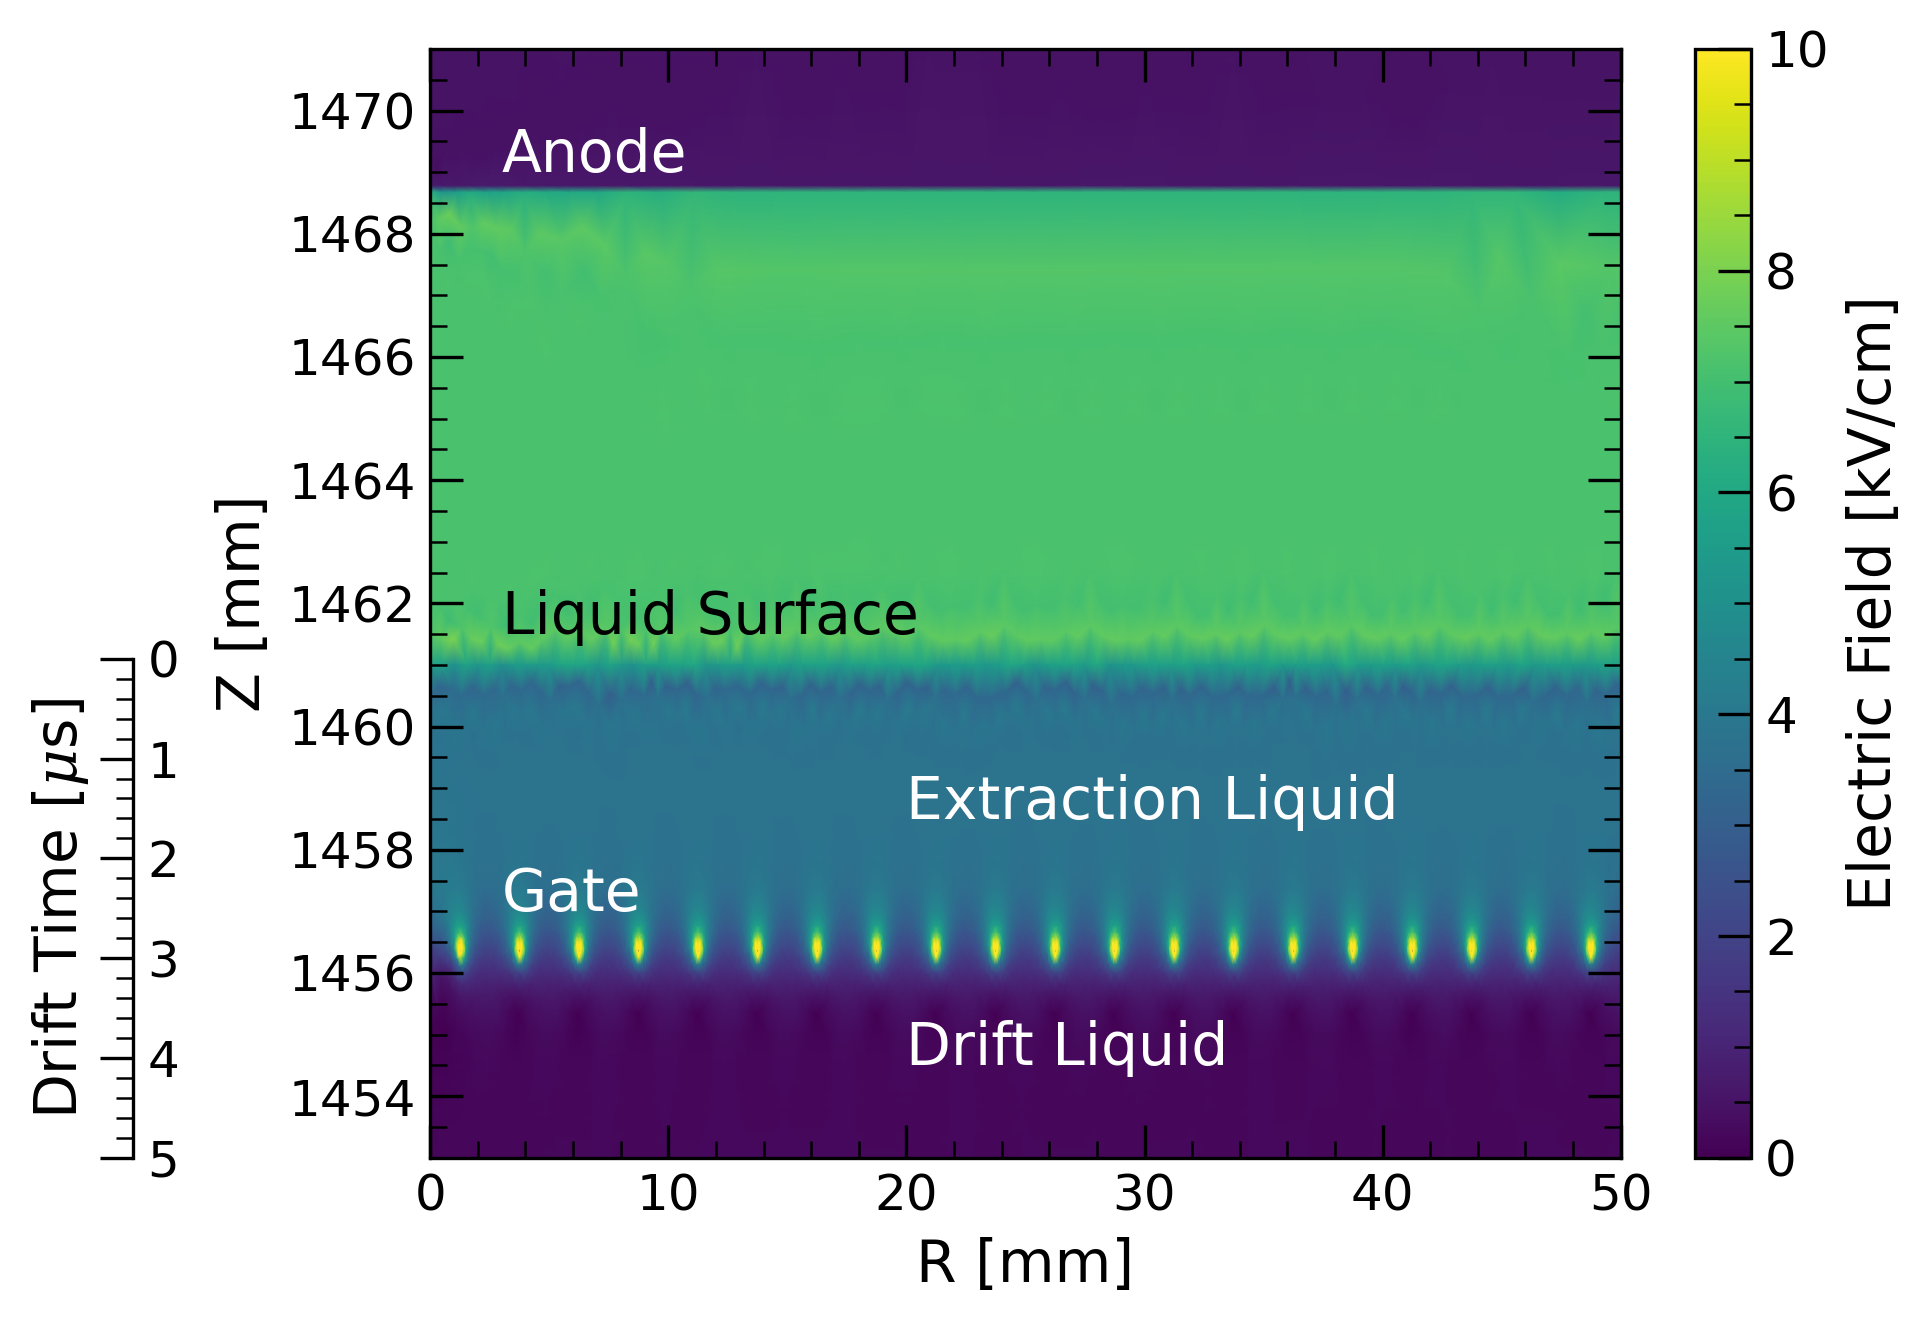

In [8]:
# | label: sr1-exl-field

fig

## Field Data

In [2]:
field_data = pd.read_parquet("field_data.parquet")

In [3]:
rlim = (5, 55)
z_exl = (145.8, 146)
z_drl = (25, 125)

exl_df = field_data[
    (field_data["r_cm"] > rlim[0])
    & (field_data["r_cm"] < rlim[1])
    & (field_data["z_cm"] > z_exl[0])
    & (field_data["z_cm"] < z_exl[1])
].copy()
exl_df["Region"] = "Extraction Liquid [kV/cm]"

drl_df = field_data[
    (field_data["r_cm"] > rlim[0])
    & (field_data["r_cm"] < rlim[1])
    & (field_data["z_cm"] > z_drl[0])
    & (field_data["z_cm"] < z_drl[1])
].copy()
drl_df["Region"] = "Drift Liquid [kV/cm]"

In [4]:
exl_df

norm_E_V_per_cm       r_cm        z_cm  Anode [kV]  Cathode [kV]  \
140338      4030.938390   5.135864  145.952586         4.0         -39.1   
140339      4025.684667   5.285871  145.952788         4.0         -39.1   
140340      4034.554350   5.735000  145.950063         4.0         -39.1   
140342      4031.937206   5.435788  145.953054         4.0         -39.1   
140343      4030.524959   5.585816  145.952848         4.0         -39.1   
...                 ...        ...         ...         ...           ...   
889499      4537.301308   6.866165  145.925601         4.5         -32.1   
889502      4638.749109  53.619954  145.968068         4.5         -32.1   
889512      4621.890112  12.464757  145.995556         4.5         -32.1   
889556      4531.677335   7.013360  145.925402         4.5         -32.1   
889561      4734.478795  43.859744  145.985477         4.5         -32.1   

        Gate [kV]                     Region  
140338       -4.0  Extraction Liquid [kV/cm]  
140339       -4.0  Extraction Liquid [kV/cm]  
140340       -4.0  Extraction Liquid [kV/cm]  
140342       -4.0  Extraction Liquid [kV/cm]  
140343       -4.0  Extraction Liquid [kV/cm]  
...           ...                        ...  
889499       -4.5  Extraction Liquid [kV/cm]  
889502       -4.5  Extraction Liquid [kV/cm]  
889512       -4.5  Extraction Liquid [kV/cm]  
889556       -4.5  Extraction Liquid [kV/cm]  
889561       -4.5  Extraction Liquid [kV/cm]  

[18025 rows x 7 columns]

In [9]:
# | label: voltage-to-fields
# | output: asis

# need print to format newlines correctly
print(
    pd.concat([exl_df, drl_df])
    .pivot_table(
        values="norm_E_V_per_cm",
        columns="Region",
        index=["Anode [kV]", "Gate [kV]", "Cathode [kV]"],
        aggfunc="mean",
    )
    .astype(np.uint16)
    .to_markdown(
        headers=[
            "Anode [kV], Gate [kV], Cathode [kV]",
            "Drift Liquid [kV/cm]",
            "Drift Liquid [kV/cm]",
        ]
    )
)

| Anode [kV], Gate [kV], Cathode [kV]   |   Drift Liquid [kV/cm] |   Drift Liquid [kV/cm] |
|:--------------------------------------|-----------------------:|-----------------------:|
| (3.5, -3.5, -32.1)                    |                    197 |                   3487 |
| (4.0, -4.0, -39.1)                    |                    242 |                   3986 |
| (4.0, -4.0, -32.1)                    |                    194 |                   3984 |
| (4.0, -4.0, -20.1)                    |                    112 |                   3981 |
| (4.5, -4.5, -32.1)                    |                    191 |                   4481 |
